## Practical 1: word2vec
<p>Oxford CS - Deep NLP 2017<br>
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/</p>
<p>[Yannis Assael, Brendan Shillingford, Chris Dyer]</p>

- Modify so that embeddings generated only from training set
- Add all the other changes
- Please finish and don't drop

This practical is presented as an IPython Notebook, with the code written for recent versions of **Python 3**. The code in this practical will not work with Python 2 unless you modify it. If you are using your own Python installation, ensure you have a setup identical to that described in the installation shell script (which is intended for use with the department lab machines). We will be unable to support installation on personal machines due to time constraints, so please use the lab machines and the setup script if you are unfamiliar with how to install Anaconda.

To execute a notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

In [2]:
import numpy as np
import tensorflow as tf
import os
from random import shuffle
import re
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
% matplotlib inline

### Part 0: Download the TED dataset

In [3]:
import urllib.request
import zipfile
import lxml.etree


In [4]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve(
        "https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip",
                               filename="ted_en-20160408.zip")

In [5]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = doc.xpath('//content/text()')
tags = doc.xpath('//keywords/text()')


### Part 1: Preprocessing

In this part, we attempt to clean up the raw subtitles a bit, so that we get only sentences. The following substring shows examples of what we're trying to get rid of. Since it's hard to define precisely what we want to get rid of, we'll just use some simple heuristics.

Let's start by removing all parenthesized strings using a regex:

In [6]:
input_text_noparens = [re.sub(r'\([^)]*\)', '', text) 
                       for text in input_text]

In [7]:
texts = [re.sub(r"[^a-z0-9]+", " ", text.lower()) 
         for text in input_text_noparens]

In [8]:
from gensim.models import Word2Vec

In [9]:
tokenized = [text.split(" ") for text in texts]

In [10]:
shuffle = np.random.permutation(np.arange(len(tokenized)))

In [11]:
shuffled_texts = []
for i in shuffle:
    shuffled_texts.append(tokenized[i])

In [12]:
train = shuffled_texts[:-500]
val = shuffled_texts[-500:-250]
test = shuffled_texts[-250:]

In [13]:
len(train),len(val),len(test)

(1585, 250, 250)

In [14]:
from collections import Counter, defaultdict

In [15]:
train_words = [word for text in train for word in text]

In [16]:
vocab = dict(Counter(train_words).most_common(10000))

In [17]:
word2id = defaultdict(lambda: 1)

In [18]:
word2id.update(dict(zip(vocab.keys(),range(1,len(vocab)+2))))

In [19]:
id2word = {0:'<PAD>', 1:'<UNK>'}
id2word.update(dict(zip(word2id.keys(), word2id.values())))

In [20]:
def get_padded_inputs(texts,max_len=None,sample=None):
    max_text_len = max(map(len,texts))
    max_len = max_len or max_text_len
    sampled = [text[::sample][:max_len] for text in texts]
    inputs = np.array([np.concatenate(([word2id[word] for word in text],
                                       np.zeros((max_len-len(text))))) 
                       for text in sampled], 
                       dtype = np.int32)
    return inputs
    

Labels

Each document should be labeled with label from the set: {Too, oEo, ooD, TEo, ToD, oED, TED, ooo}. You are called to generate labels from the <keywords> tag by checking the existence of one of the following tags: {Technology, Entertainment, Design}.

- None of the keywords → ooo
- “Technology” → Too
- “Entertainment” → oEo
- “Design” → ooD
- “Technology” and “Entertainment” → TEo
- “Technology” and “Design” → ToD
- “Entertainment” and “Design” → oED
- “Technology” and “Entertainment” and “Design” → TED

In [21]:
def batch_normalize(X,is_tr,eps=1e-5,momentum=0.9):
    moments_shape = (1,X.get_shape()[-1].value)
    running_mean = tf.get_variable('rm',shape=moments_shape,trainable=False,
                                   initializer=tf.zeros_initializer())
    running_var = tf.get_variable('rv',shape=moments_shape,trainable=False,
                                  initializer=tf.ones_initializer())

    mu,var = tf.nn.moments(X,axes=[0],keep_dims=True)

    gamma = tf.get_variable('gamma',shape=moments_shape)
    beta = tf.get_variable('beta',shape=moments_shape)

    bn = tf.nn.batch_normalization(
            X,
            tf.cond(is_tr,lambda:mu,lambda:running_mean),
            tf.cond(is_tr,lambda:var,lambda:running_var),
            gamma,
            beta,
            eps
        )

    tf.cond(is_tr,lambda:update_moments(running_mean,running_var,mu,var,momentum),tf.no_op)

    return bn

In [22]:
def update_moments(running_mean,running_var,mu,var,momentum):
    old_weight = momentum
    new_weight = 1-momentum
    tf.add_to_collection(
        tf.assign(running_mean,old_weight*running_mean + new_weight*mu),
        tf.GraphKeys.UPDATE_OPS
        )
    tf.add_to_collection(
        tf.assign(running_var, old_weight*running_var + new_weight*var),
        tf.GraphKeys.UPDATE_OPS
        )
    return tf.no_op()

In [23]:
class RNNClassifier():

    def __init__(self,  
                embed_dim,
                vocab_size,
                num_classes,
                num_dense,
                cell,
                num_units,
                start_lr,
                lr_decay = 0.5,
                layers = 1,
                rate_drop_rnn = 0.25,
                rate_drop_dense = 0.5,
                optimizer=tf.train.AdamOptimizer,
                use_final_only=False,
                ):
        self.rate_drop_rnn_ = rate_drop_rnn
        self.rate_drop_dense_ = rate_drop_dense
        self.layers = layers
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.cell = cell
        self.num_units = num_units
        self.num_classes = num_classes
        self.num_dense = num_dense
        self.optimizer = optimizer
        self.use_final_only = use_final_only
        self.start_lr = start_lr
        self.lr_decay = lr_decay
        
    def build_graph(self):
        if 'sess' in globals() and sess:
            sess.close()
        tf.reset_default_graph()
        is_train = tf.placeholder(tf.bool,name='is_train')
        X = tf.placeholder(tf.int32, [None,None],name='X')
        seqlens = tf.placeholder(tf.int32, [None],name='seqlens')
        y = tf.placeholder(tf.int32,[None],name='y')
        self.learn_rate = tf.placeholder(tf.float32,name='learn_rate')
        
        self.rate_drop_rnn = tf.placeholder(tf.float32,name='rate_drop_rnn')
        self.rate_drop_dense = tf.placeholder(tf.float32,name='rate_drop_dense')
        
        with tf.variable_scope('embed'):
            embeddings = tf.get_variable('embeddings',
                                        [self.vocab_size, self.embed_dim],
                                        dtype=tf.float32,
                                        trainable=True)
            rnn_inputs = tf.nn.embedding_lookup(embeddings, X)
            
        with tf.variable_scope('lstm'):
            cells = []
            for i in range(2):
                cell = self.cell(self.num_units)
                cell = tf.contrib.rnn.DropoutWrapper(cell, 
                                                     output_keep_prob=self.rate_drop_rnn)
                cell = tf.contrib.rnn.MultiRNNCell([cell] * self.layers)
                cells.append(cell)
            rnn_outputs, final_state = tf.nn.dynamic_rnn(cell=cells[0],
                                                         inputs=rnn_inputs,
                                                         sequence_length = seqlens,
                                                         dtype = tf.float32)
            if self.use_final_only:
                if type(final_state) is tuple:
                    text_vec = final_state[0].h
                else:
                    text_vec = final_state
            else:
                text_vec = tf.reduce_sum(rnn_outputs,axis=1)/tf.cast(
                    tf.expand_dims(seqlens,axis=1), dtype=tf.float32)
                
#         with tf.variable_scope('bn1'):
#             text_vec = batch_normalize(text_vec,is_train)
    
        with tf.variable_scope('fc1'):
            colms = X.get_shape()[-1].value
            W1 = tf.get_variable('W1',shape=[self.num_units,self.num_dense])
            b1 = tf.get_variable('b1',shape=[self.num_dense])

            text_vec = tf.nn.xw_plus_b(text_vec,W1,b1)
            text_vec = tf.tanh(text_vec)
            text_vec = tf.nn.dropout(text_vec,self.rate_drop_dense)

#         with tf.variable_scope('bn2'):
#             text_vec = batch_normalize(text_vec,is_train)

        with tf.variable_scope('softmax'):
            W_out = tf.get_variable('W_out', [self.num_dense, self.num_classes])
            b_out = tf.get_variable('b_out', [self.num_classes],
                initializer=tf.constant_initializer(0.0))
            logits = tf.nn.xw_plus_b(text_vec,W_out,b_out)

            preds = tf.nn.softmax(logits)
            correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32),y)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

            loss = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
            )

        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        with tf.control_dependencies(extra_update_ops):
             train_step = self.optimizer(self.learn_rate).minimize(loss)
        
        self.X = X
        self.y = y
        self.seqlens = seqlens
        self.loss = loss
        self.preds = preds
        self.train_step = train_step
        self.is_train = is_train
        self.accuracy = accuracy

    
    def test(self,data):
        x_test,y_test = data
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess,'./')
            feed = {self.is_train: False,
                    self.X: x_test,
                    self.y: y_test}
            acc = sess.run([self.accuracy], feed_dict=feed)
        return acc
    
    def get_preds(self,data):
        x_test,y_test = data
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess,'./')
            feed = self.make_feed_dict(x_test,y_test,False)
            preds = sess.run([self.preds], feed_dict=feed)
        return np.argmax(preds[0],axis=1)
    
    
    def make_feed_dict(self,x,y,is_train,learn_rate=None,seqlens=True):
        feed = {self.X:x, 
                self.y:y, 
                self.is_train: is_train,
                self.rate_drop_dense: 1.*(not is_train or self.rate_drop_dense_),
                self.rate_drop_rnn: 1.*(not is_train or self.rate_drop_rnn_)
               }
        if seqlens:
            feed[self.seqlens] = list(map(len,x))
        if learn_rate:
            feed[self.learn_rate] = learn_rate
        return feed
        
    def train(self,
                    data,
                    verbose=False,
                    batch_size = 50,
                    num_epochs = 100, 
                    skip_step=10):

        (x_train,y_train),(x_test,y_test) = [data['train'],data['test']]

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            self.tr_accs, self.te_accs = [], []
            self.tr_losses, self.te_losses = [], []

            train_size = x_train.shape[0]

            lr = self.start_lr
            for epoch in range(num_epochs):
                if epoch > 1 and ((epoch%5)==0):
                    lr*=self.lr_decay
                        
                    
                shuffle = np.random.permutation(np.arange(train_size))
                x_train = x_train[shuffle,:]
                y_train = y_train[shuffle]
                
                accuracy = 0
                losses = []

                for i in range(math.ceil(train_size/batch_size)):
                    ix = slice(i*batch_size,(i+1)*batch_size)
                    
                    feed = self.make_feed_dict(x_train[ix,:],y_train[ix], 
                                               is_train = True, learn_rate=lr)
                
                    acc,_,loss = sess.run([self.accuracy,
                                          self.train_step,
                                          self.loss], 
                                          feed_dict=feed)

                    actual_batch_size = x_train[ix,:].shape[0]
                    losses.append(loss*actual_batch_size)
                    accuracy += acc*actual_batch_size


                feed = self.make_feed_dict(x_test, y_test, is_train=False)

                val_acc,val_loss = sess.run([self.accuracy,self.loss], feed_dict=feed)

                total_tr_acc = accuracy/x_train.shape[0]
                total_tr_loss = np.sum(losses)/x_train.shape[0]
                if(verbose):
                    print("Epoch {2}, Overall training loss = {0:.3g} and accuracy of {1:.3g}"\
                      .format(total_tr_loss,total_tr_acc,epoch+1))
                    print("Epoch {2}, Overall validation loss = {0:.3g} and accuracy of {1:.3g}"\
                      .format(val_loss,val_acc,epoch+1))

                for val,lst in zip((total_tr_loss,val_loss,total_tr_acc,val_acc),
                                   (self.tr_losses,self.te_losses,self.tr_accs,self.te_accs)):
                    lst.append(val)
            
            saver = tf.train.Saver()
            saver.save(sess,'./')

    def plot(self):
            for i,j in zip(('Train Loss','Val Loss','Train Acc','Val Acc'),
                        [ self.tr_losses, self.te_losses, self.tr_accs, self.te_accs]):
                print(i,j[-1])
            plt.figure(figsize=(16,8))
            plt.subplot(1,2,1)
            plt.plot(self.tr_losses,label='train')
            plt.plot(self.te_losses,label='valid')
            plt.title('Loss per epoch')
            plt.legend()
            plt.subplot(1,2,2)
            plt.plot(self.tr_accs,label='train')
            plt.plot(self.te_accs,label='valid')
            plt.title('Accuracy per epoch')
            plt.legend()

    def train_and_plot(self,
                    data,
                    verbose=False,
                    batch_size = 50,
                    num_epochs = 100, 
                    skip_step=10):
        self.train(data=data,verbose=verbose,
                   batch_size=batch_size,num_epochs=num_epochs, skip_step=skip_step)
        self.plot()

In [24]:
import itertools

def make_label(comb):
    return ''.join([let if num else 'o' for (let,num) in zip('TED',comb)])

all_labels = [make_label(comb) for comb in itertools.product(*[[0,1]]*3)]

label_dict = dict(zip(all_labels ,range(8)))


In [25]:
label_dict

{'TED': 7,
 'TEo': 6,
 'ToD': 5,
 'Too': 4,
 'oED': 3,
 'oEo': 2,
 'ooD': 1,
 'ooo': 0}

In [26]:
tags = [tags_i.lower() for tags_i in tags]
labels = [make_label([tags_i.find(tag) >-1 for tag in ['technology','entertainment','design']]) 
          for tags_i in tags]

num_labels = np.array(list(map(label_dict.get,labels)))


shuffled_labels = num_labels[shuffle]

y_train = shuffled_labels[:-500]
y_val = shuffled_labels[-500:-250]
y_test = shuffled_labels[-250:]

In [27]:
train_ids, val_ids, test_ids = [get_padded_inputs(data,2000) for data in (train,val,test)]

In [28]:
def expand_data(X,y,length=100):
    X_expanded = []
    y_expanded = []
    for y_i,x in zip(y,X):
        num = len(x)//length
        y_expanded.extend([y_i]*num)
        for i in range(num):
            X_expanded.append(x[i*length:(i+1)*length])
    return np.array(X_expanded), np.array(y_expanded)
        

In [29]:
rnn = RNNClassifier(embed_dim = 300,
                    vocab_size = 10002,
                    num_classes = 8,
                    num_dense = 150,
                    cell = tf.contrib.rnn.LSTMCell,
                    num_units = 150,
                    layers = 1,
                    rate_drop_rnn = 0.6,
                    rate_drop_dense = 0.6,
                    optimizer = tf.train.AdamOptimizer,
                    start_lr = 1e-3,
                    lr_decay = 0.7,
                    use_final_only=False
                    )

In [30]:
rnn.build_graph()

In [31]:
import timeit

In [32]:
expand_data(train_ids,y_train)[-1].shape

(31700,)

Epoch 1, Overall training loss = 2.12 and accuracy of 0
Epoch 1, Overall validation loss = 2.04 and accuracy of 0.6
Epoch 2, Overall training loss = 2.09 and accuracy of 0
Epoch 2, Overall validation loss = 2.02 and accuracy of 0.6
Epoch 3, Overall training loss = 2.02 and accuracy of 0.2
Epoch 3, Overall validation loss = 1.98 and accuracy of 0.6
Epoch 4, Overall training loss = 1.98 and accuracy of 0.4
Epoch 4, Overall validation loss = 1.93 and accuracy of 0.6
Epoch 5, Overall training loss = 1.99 and accuracy of 0.4
Epoch 5, Overall validation loss = 1.86 and accuracy of 0.6
Epoch 6, Overall training loss = 1.88 and accuracy of 0.4
Epoch 6, Overall validation loss = 1.79 and accuracy of 0.6
Epoch 7, Overall training loss = 1.8 and accuracy of 0.4
Epoch 7, Overall validation loss = 1.67 and accuracy of 0.6
Epoch 8, Overall training loss = 1.74 and accuracy of 0.4
Epoch 8, Overall validation loss = 1.51 and accuracy of 0.6
Epoch 9, Overall training loss = 1.53 and accuracy of 0.4
Epo

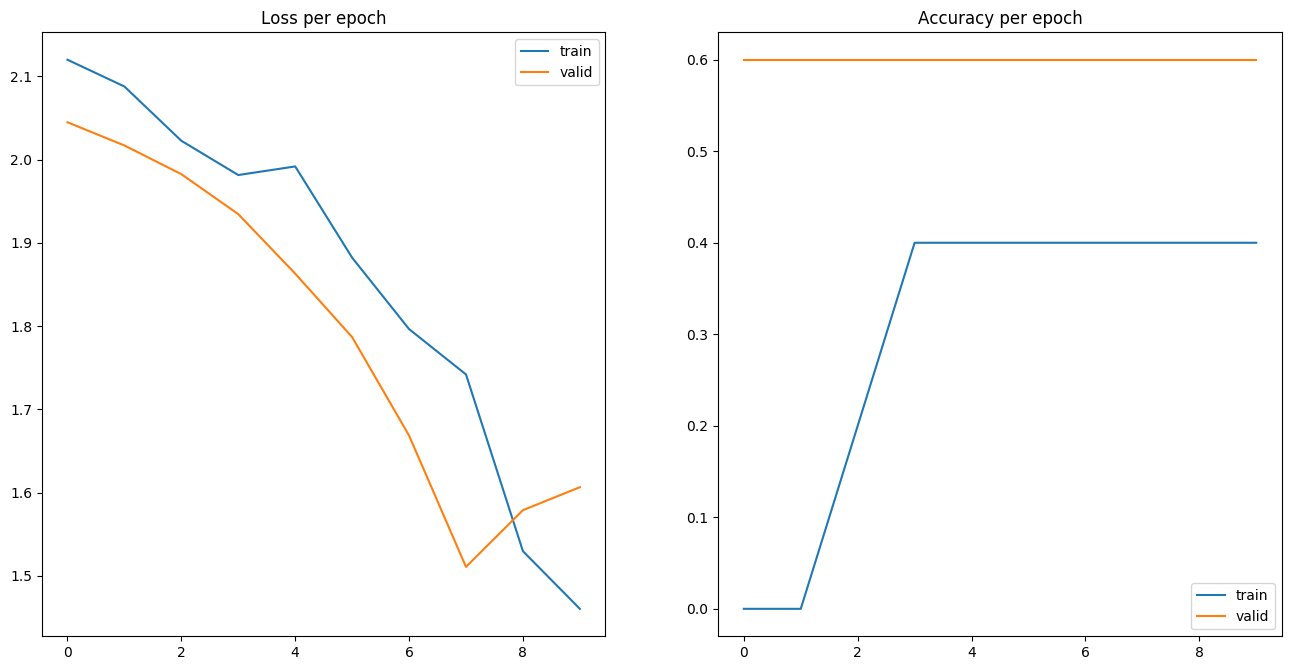

In [34]:
t = timeit.default_timer()
data = {'train':(train_ids[:10],y_train[:10]),'test':(val_ids[:10], y_val[:10])}
rnn.train_and_plot(data,num_epochs=10, verbose = True)
print(timeit.default_timer()-t)

In [137]:
train_ids, val_ids, test_ids = [get_padded_inputs(data,2000) for data in (train,val,test)]

In [150]:
rnn = RNNClassifier(embed_dim = 300,
                    vocab_size = 10002,
                    num_classes = 8,
                    num_dense = 150,
                    cell = tf.contrib.rnn.LSTMCell,
                    num_units = 150,
                    layers = 1,
                    rate_drop_rnn = 0.6,
                    rate_drop_dense = 0.6,
                    optimizer = tf.train.AdamOptimizer,
                    start_lr = 5e-3,
                    lr_decay = 0.7,
                    use_final_only=False
                    )

In [151]:
rnn.build_graph()

Epoch 1, Overall training loss = 1.51 and accuracy of 0.522
Epoch 1, Overall validation loss = 1.27 and accuracy of 0.584
Epoch 2, Overall training loss = 1.13 and accuracy of 0.609
Epoch 2, Overall validation loss = 1.17 and accuracy of 0.608
Epoch 3, Overall training loss = 0.685 and accuracy of 0.762
Epoch 3, Overall validation loss = 1.26 and accuracy of 0.612
Epoch 4, Overall training loss = 0.367 and accuracy of 0.882
Epoch 4, Overall validation loss = 1.77 and accuracy of 0.572
Epoch 5, Overall training loss = 0.173 and accuracy of 0.936
Epoch 5, Overall validation loss = 2.81 and accuracy of 0.6
Epoch 6, Overall training loss = 0.136 and accuracy of 0.954
Epoch 6, Overall validation loss = 2.39 and accuracy of 0.592
Epoch 7, Overall training loss = 0.0634 and accuracy of 0.979
Epoch 7, Overall validation loss = 2.38 and accuracy of 0.548
Epoch 8, Overall training loss = 0.0348 and accuracy of 0.987
Epoch 8, Overall validation loss = 2.64 and accuracy of 0.58
Epoch 9, Overall tr

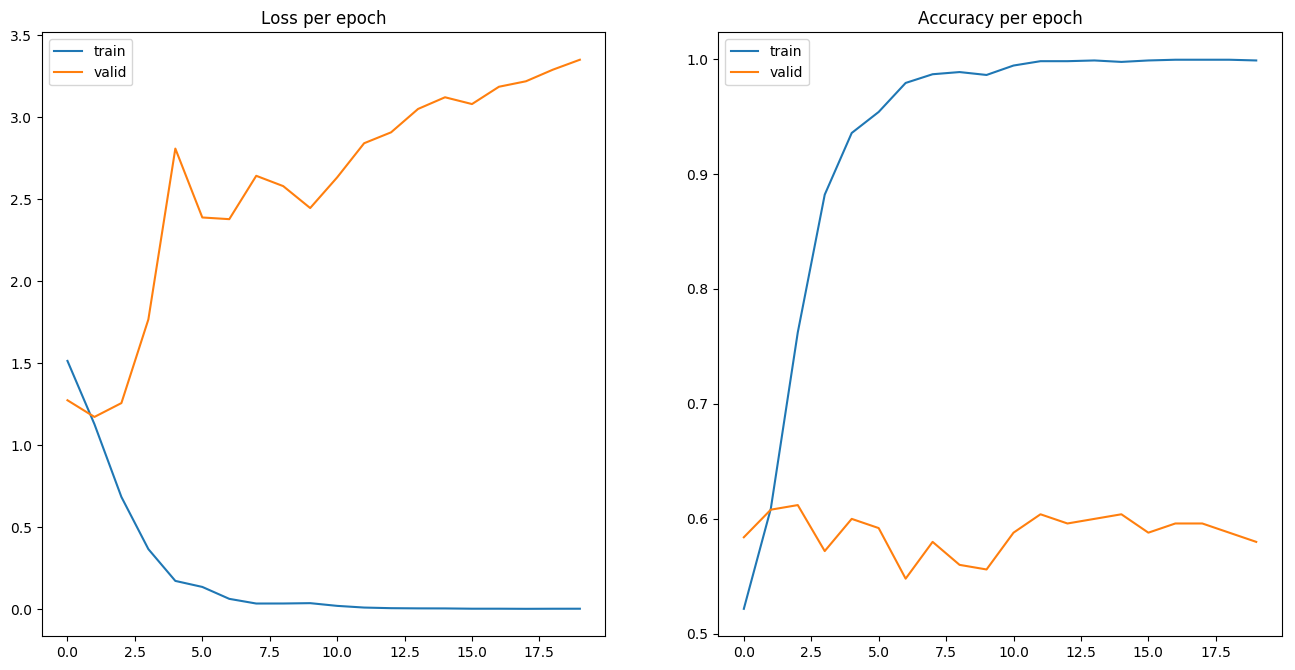

In [152]:
t = timeit.default_timer()
data = {'train':(train_ids,y_train),'test':(val_ids, y_val)}
rnn.train_and_plot(data,num_epochs=20, verbose = True)
print(timeit.default_timer()-t)

In [143]:
rnn = RNNClassifier(embed_dim = 300,
                    vocab_size = 10002,
                    num_classes = 8,
                    num_dense = 150,
                    cell = tf.contrib.rnn.LSTMCell,
                    num_units = 150,
                    layers = 1,
                    rate_drop_rnn = 0.6,
                    rate_drop_dense = 0.6,
                    optimizer = tf.train.AdamOptimizer,
                    start_lr = 5e-3,
                    lr_decay = 0.7,
                    use_final_only=True
                    )

In [144]:
rnn.build_graph()

Epoch 1, Overall training loss = 1.56 and accuracy of 0.51
Epoch 1, Overall validation loss = 1.39 and accuracy of 0.556
Epoch 2, Overall training loss = 1.31 and accuracy of 0.58
Epoch 2, Overall validation loss = 1.58 and accuracy of 0.52
Epoch 3, Overall training loss = 1 and accuracy of 0.681
Epoch 3, Overall validation loss = 1.85 and accuracy of 0.44
Epoch 4, Overall training loss = 0.813 and accuracy of 0.755
Epoch 4, Overall validation loss = 2 and accuracy of 0.46
Epoch 5, Overall training loss = 0.748 and accuracy of 0.774
Epoch 5, Overall validation loss = 2.31 and accuracy of 0.484
Epoch 6, Overall training loss = 0.686 and accuracy of 0.785
Epoch 6, Overall validation loss = 2.38 and accuracy of 0.492
Epoch 7, Overall training loss = 0.677 and accuracy of 0.787
Epoch 7, Overall validation loss = 2.39 and accuracy of 0.476
Epoch 8, Overall training loss = 0.671 and accuracy of 0.791
Epoch 8, Overall validation loss = 2.65 and accuracy of 0.464
Epoch 9, Overall training loss

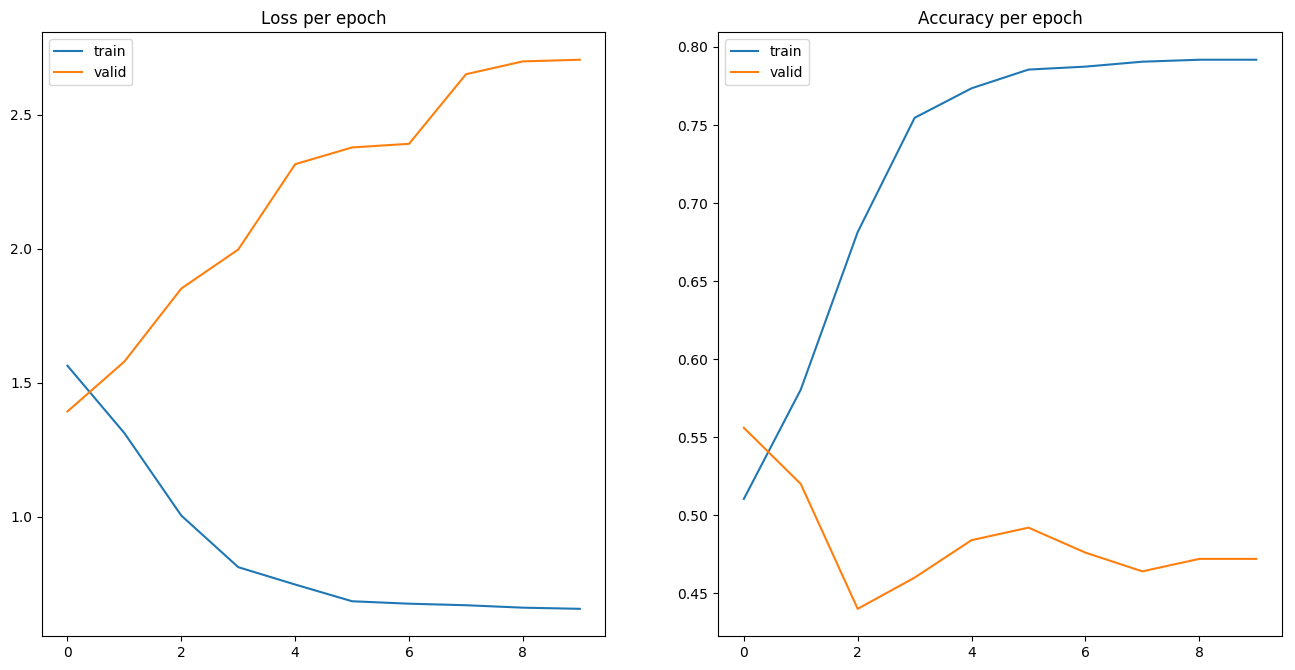

In [145]:
t = timeit.default_timer()
data = {'train':(train_ids,y_train),'test':(val_ids, y_val)}
rnn.train_and_plot(data,num_epochs=10, verbose = True)
print(timeit.default_timer()-t)

Epoch 1, Overall training loss = 1.59 and accuracy of 0.514
Epoch 1, Overall validation loss = 1.41 and accuracy of 0.556
Epoch 2, Overall training loss = 1.13 and accuracy of 0.62
Epoch 2, Overall validation loss = 1.67 and accuracy of 0.448
Epoch 3, Overall training loss = 0.592 and accuracy of 0.811
Epoch 3, Overall validation loss = 2.01 and accuracy of 0.48
Epoch 4, Overall training loss = 0.339 and accuracy of 0.888
Epoch 4, Overall validation loss = 2.43 and accuracy of 0.408
Epoch 5, Overall training loss = 0.149 and accuracy of 0.951
Epoch 5, Overall validation loss = 3 and accuracy of 0.404
Epoch 6, Overall training loss = 0.0952 and accuracy of 0.97
Epoch 6, Overall validation loss = 3.28 and accuracy of 0.428
Epoch 7, Overall training loss = 0.0744 and accuracy of 0.97
Epoch 7, Overall validation loss = 3.63 and accuracy of 0.412
Epoch 8, Overall training loss = 0.0702 and accuracy of 0.976
Epoch 8, Overall validation loss = 3.73 and accuracy of 0.416
Epoch 9, Overall train

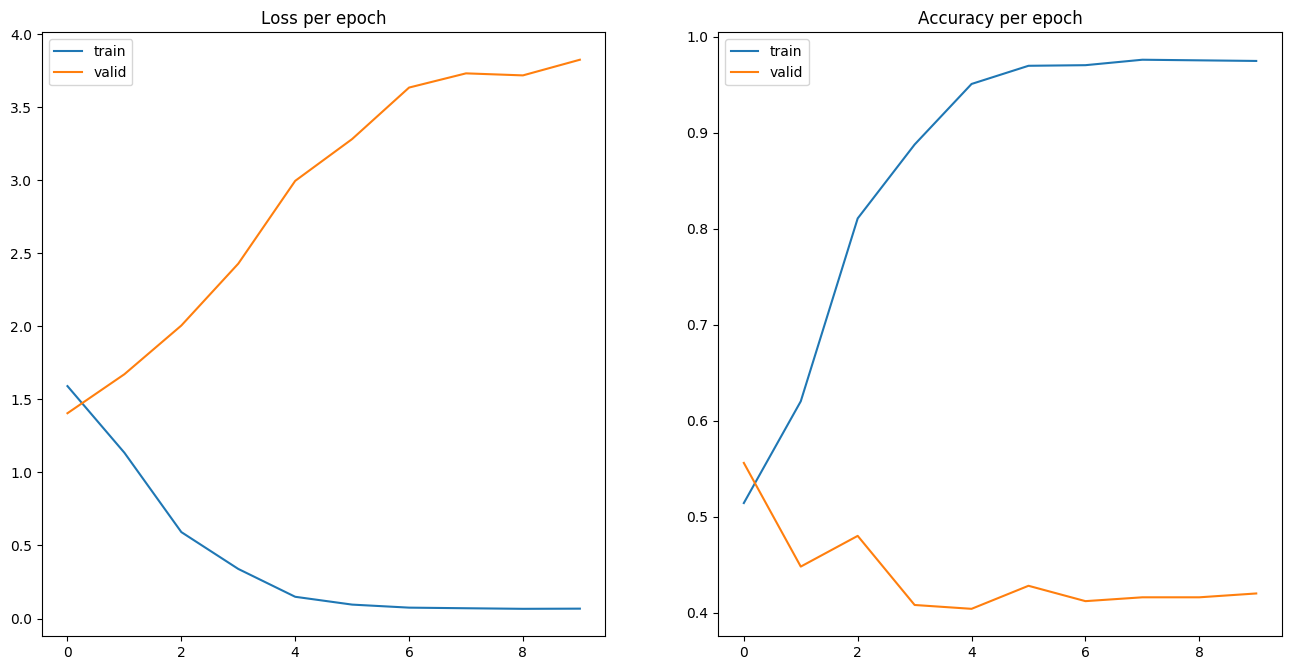

In [146]:
train_ids, val_ids, test_ids = [get_padded_inputs(data,500) for data in (train,val,test)]
rnn = RNNClassifier(embed_dim = 300,
                    vocab_size = 10002,
                    num_classes = 8,
                    num_dense = 150,
                    cell = tf.contrib.rnn.LSTMCell,
                    num_units = 150,
                    layers = 1,
                    rate_drop_rnn = 0.6,
                    rate_drop_dense = 0.6,
                    optimizer = tf.train.AdamOptimizer,
                    start_lr = 5e-3,
                    lr_decay = 0.7,
                    use_final_only=True
                    )
rnn.build_graph()

t = timeit.default_timer()
data = {'train':(train_ids,y_train),'test':(val_ids, y_val)}
rnn.train_and_plot(data,num_epochs=10, verbose = True)
print(timeit.default_timer()-t)